In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

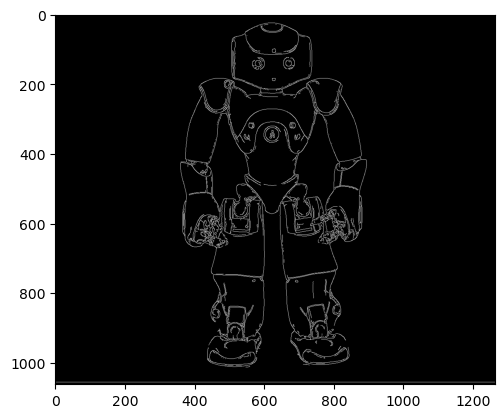

In [4]:
img=cv2.imread("robot.png",cv2.IMREAD_GRAYSCALE)
imgc=(cv2.Canny(img,50,100))
plt.imshow(imgc,cmap="gray",vmin=0,vmax=255)

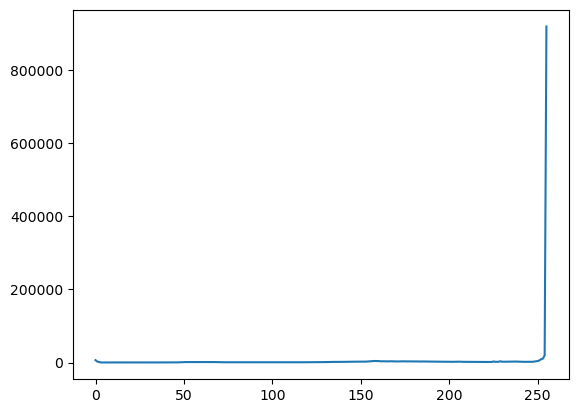

In [5]:
hist=cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(hist)

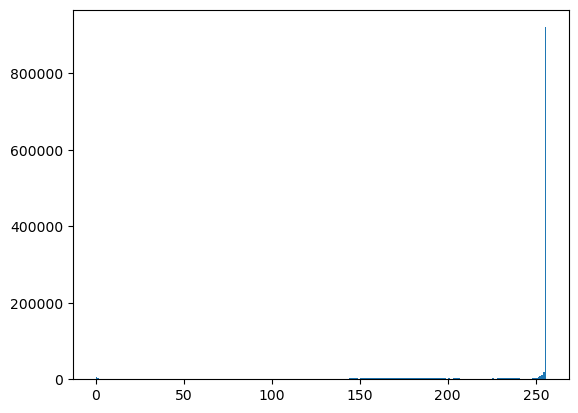

In [6]:
plt.hist(img.ravel(),256,[0,256])
plt.show()

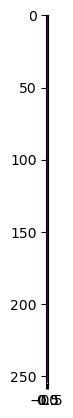

In [7]:
mask=np.zeros(img.shape[:2],np.uint8) #sets the first two dimensions height and width as zeros
mask[0:200,400:800]=255 #these regions are set to white and rest are all black i.e., 0
maskimg=cv2.bitwise_and(img,img,mask=mask) #and on each pixel of both src's and mask will set all non-zero elements to mask
histmask=cv2.calcHist([img],[0],mask,[256],[0,256])
plt.imshow(histmask)
plt.show()

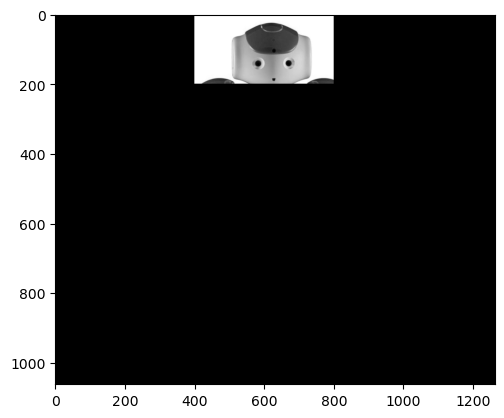

In [8]:
plt.imshow(maskimg,cmap="gray")

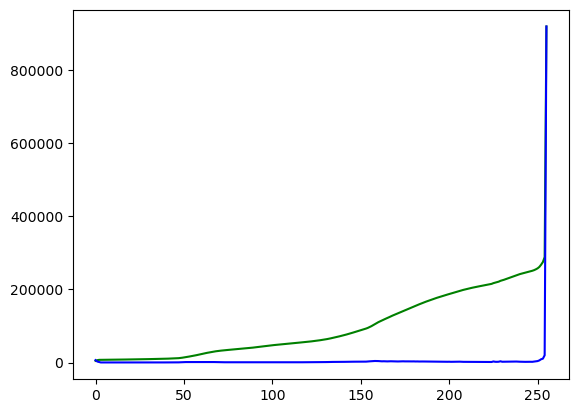

In [9]:
hist,bins=np.histogram(img.flatten(),256,[0,256]) #main diff b/w .flattened() and .ravel() is .flattened() retruns a new flatterned array while the latter dosent 
#hist is the flattened matrix while bin is 256
cdf=hist.cumsum() #cumilative sum
cdfnor=cdf*float(hist.max()/cdf.max()) #normalizes the cdf
plt.plot(cdfnor , color="g")
plt.plot(hist,color="b")
#it is clearly observable that histogram is highly concentrated in the lighter region i.e., 250-55

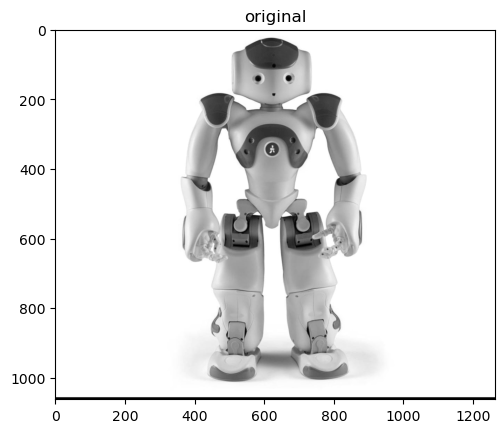

In [10]:
cdf_m=np.ma.masked_equal(cdf,0) #masks all 0's in cdf array
cdf_m=(cdf_m-cdf_m.min())*255/(cdf_m.max()-cdf_m.min()) #range of values are now in [0,255] and are more evenly distributed by the change of cdf values
cdf=np.ma.filled(cdf_m,0) #all masked 0's are set back to 0
img2=cdf[img]
plt.title("original")
plt.imshow(img,cmap="gray")

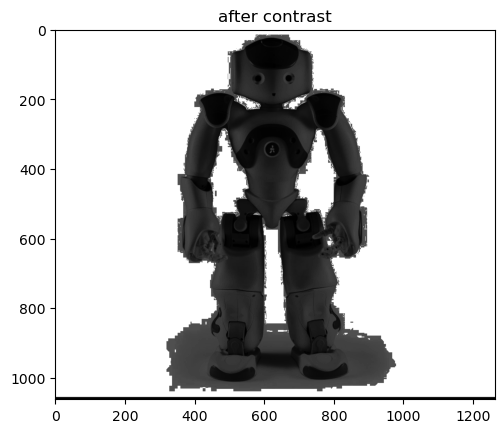

In [11]:
plt.title("after contrast")
plt.imshow(img2,cmap="gray")

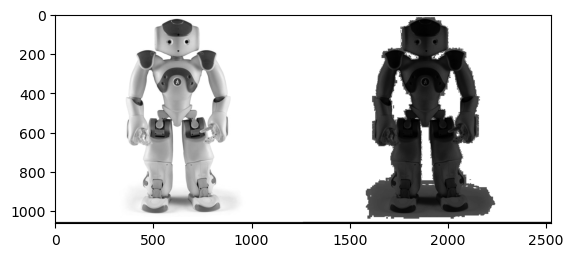

In [12]:
eq=cv2.equalizeHist(img)
res=np.hstack((img,eq)) #places both side by side
plt.imshow(res,cmap="gray")
#nothing but the same only diff is we are using opencv instead of numpy

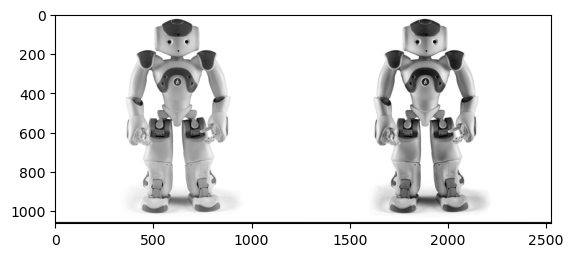

In [13]:
clahe=cv2.createCLAHE(clipLimit=1.5,tileGridSize=(8,8))
nimg=clahe.apply(img)
sideimg=np.hstack((img,nimg))
plt.imshow(sideimg,cmap="gray")

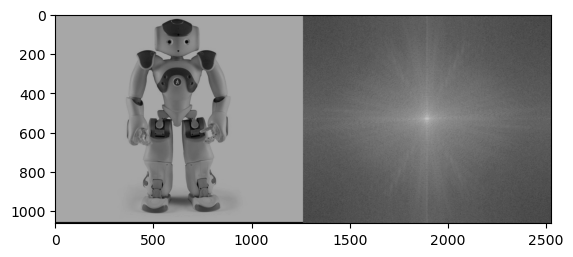

In [14]:
four=np.fft.fft2(img)
fours=np.fft.fftshift(four) #this is in complex numbers so convert to dB format
rfours=20*np.log(np.abs(fours))
final=np.hstack((img,rfours))
plt.imshow(final,cmap="gray")

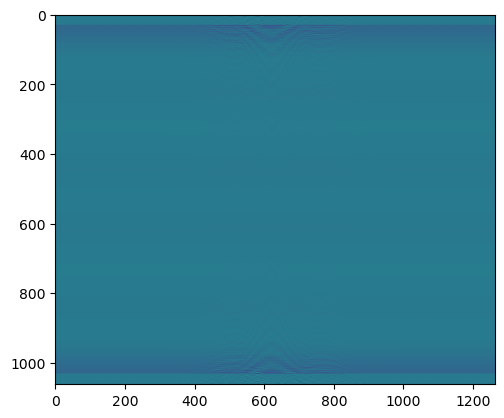

In [15]:
r,c=img.shape
cr,cc=r//2,c//2
fours[cr-30:cr+31,cc-30:cc+31]=0 #sets the 60X60 rectangular region to 0 
ishift=np.fft.ifftshift(fours)
oldimg=np.fft.ifft(ishift)
oldimgr=np.real(oldimg)
plt.imshow(oldimgr)

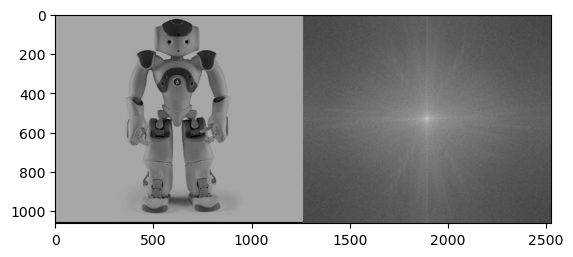

In [16]:
shift=cv2.dft(np.float32(img),flags=cv2.DFT_COMPLEX_OUTPUT) #only converts the image to frequencies using cv2.dft()
shift1=np.fft.fftshift(shift)
mag_spectrum=20*np.log(cv2.magnitude(shift1[:,:,0] ,shift1[:,:,1]))
s2s=np.hstack((img,mag_spectrum))
plt.imshow(s2s,cmap="gray")


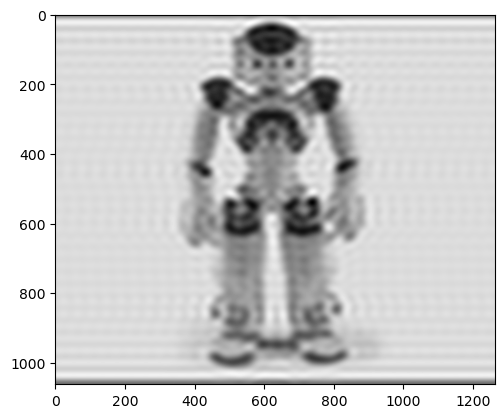

In [17]:
mask=np.zeros((r,c,2),np.uint8)
mask[cr-30:cr+31,cc-30:cc+31]=1
fshift=shift1*mask
f_shift=np.fft.ifftshift(fshift)
imgo=cv2.idft(f_shift)
imgo=cv2.magnitude(imgo[:,:,0],imgo[:,:,1])
plt.imshow(imgo,cmap="gray")

In [41]:
img1=cv2.imread("robot.png")
gray=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

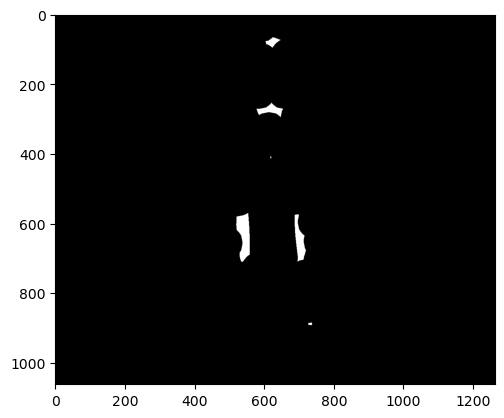

In [42]:
ret,thresh=cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #ret is the threshold value in the range of 0-255 and thresh is the grayscale image matrix obtained through THRESH_BINARY_INV
kernel=np.ones((3,3),np.uint8)
opening=cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=3) #reduceds any white noise
sbg=cv2.dilate(opening,kernel,iterations=3) #expands the borders of the morpholigically opened image
dt=cv2.distanceTransform(opening,cv2.DIST_L2,5) #produces a distance transformed image of morphological opened img by taking the dist from the bg objects where DIST_L2 is eucledian dist
ret,sfg=cv2.threshold(dt,0.7*dt.max(),255,0) #sets the threshold on the dist transformed img as 70% of the max value where the values above and below it are set to 255 and 0
sfg=np.uint8(sfg)
unknown=cv2.subtract(sbg,sfg) #computes the difference i.e., the unknown region
plt.imshow(sfg,cmap="gray")

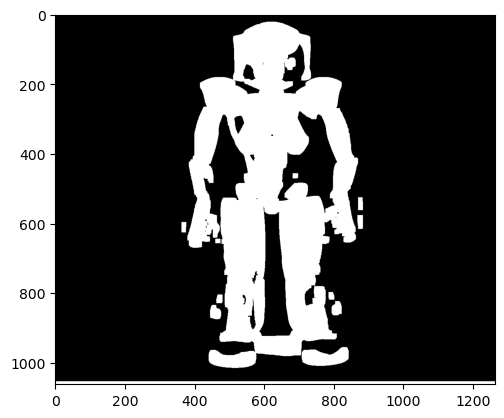

In [43]:
plt.imshow(sbg,cmap="gray")

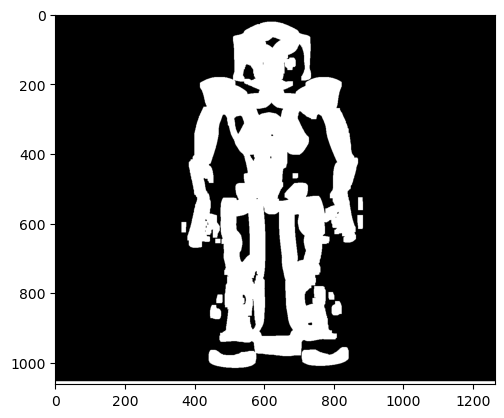

In [44]:
plt.imshow(unknown,cmap="gray")

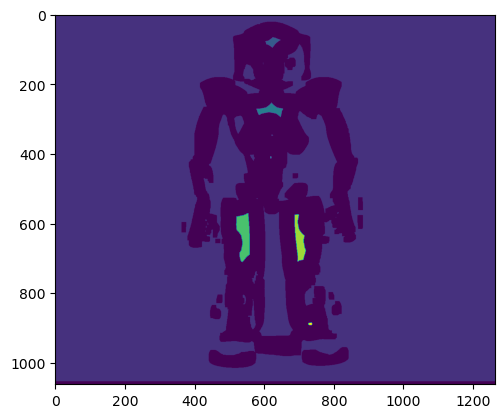

In [45]:
#setting markers
ret,markers=cv2.connectedComponents(sfg) #labels the img starting from 0(bg) and ret is the total no.of labels whereas markers is the marked img matrix
markers=markers+1 #all values are added with 1 so that the unknown can be set to 0 and bg dosent become unknown
markers[unknown==255]=0 #wherever unknown is white is set to 0
plt.imshow(markers)

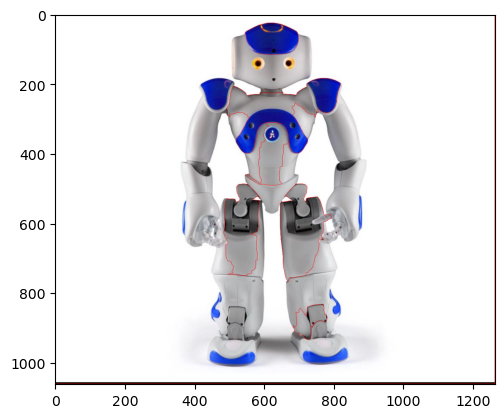

In [52]:
markers=np.int32(markers)
markers = cv2.watershed(img1,markers) #applies watershed algorithm to img1 using markers
img1[markers == -1]=[255,0,0] #wherever the boundaries are there (which are set as -1) are set to blue color
plt.imshow(img1) #but since plt.imshow() converts it to RGB while displaying so boundaries become red